# Held-Karp DP

This is an **exact** algorithm to solve TSP. 

## Prepare Data

We execute this demo on a complete undirected network with 6 vertices. 

The network can be represented as a list of edges: 

```
A, B, 35
A, c, 25
A, D, 30
A, E, 20
A, F, 10
B, C, 30
B, D, 20
B, E, 15
B, F, 15
C, D, 15
C, E, 10
C, F, 20
D, E, 25
D, F, 25
E, F, 30
```
Let's draw this network. 

In [2]:
# Prepare: Change the working directory. 
# JUST RUN IT ONCE! DON'T run this again!
# JUST MAKE SURE the current working directory output is '/OperationsResearch-Library'!
import os
BASE_DIR = os.path.abspath(".")
os.chdir(BASE_DIR)
# os.chdir('../../')
print(os.getcwd())

/OperationsResearch-Library/notebooks/network_optimization/TSP


/OperationsResearch-Library/venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


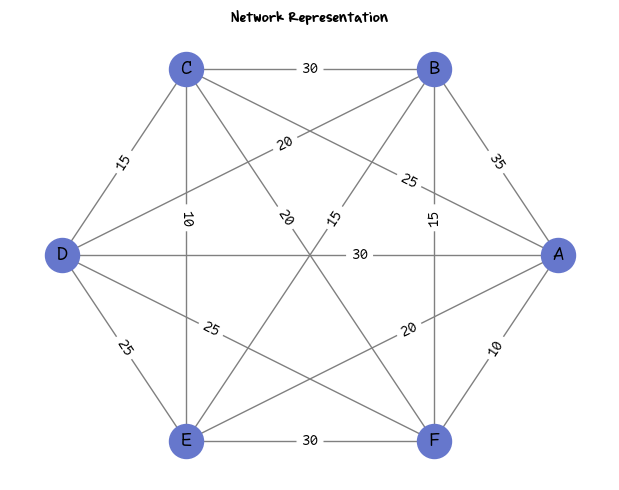

In [3]:
# Draw the network. 
from network_utils.drawer import Drawer
import network_utils.read_graph as read

edges = [['A', 'B', 35],  ['A', 'C', 25],  ['A', 'D', 30],  ['A', 'E', 20],  ['A', 'F', 10],  ['B', 'C', 30],  ['B', 'D', 20],  ['B', 'E', 15],  ['B', 'F', 15],  ['C', 'D', 15],  ['C', 'E', 10],  ['C', 'F', 20],  ['D', 'E', 25],  ['D', 'F', 25],  ['E', 'F', 30]]

G = read.get_nx_network(edges=edges, directed_graph=False, weighted_graph=True)

# Number of vertices
n = len(G.nodes)

def get_label_pos(n, edges):
    label_pos_map = {}
    # Different label positions for edges
    for u, v, _ in edges: 
        if isinstance(u, str) and isinstance(v, str):
            # If vertices are represented as strings
            if ord(v) > ord(u) and ((ord(v) - ord(u)) % n == 1 or (ord(v) - ord(u)) % n == n - 1): 
                label_pos_map[(u, v)] = 0.5
            else:
                label_pos_map[(u, v)] = 0.6
        elif isinstance(u, int) and isinstance(v, int):
            # If vertices are represented as integers
            if v > u and (v - u) % n == 1 or (v - u) % n == n - 1: 
                label_pos_map[(u, v)] = 0.5
            else:
                label_pos_map[(u, v)] = 0.6

    return label_pos_map


drawer = Drawer()
drawer.draw_network(G=G, nx_layout='circular', label_pos=0.6, label_pos_map=get_label_pos(n, edges))

Since TSP problems usually work on complete networks, that is, there exists edge between every pair of vertices, we use **distance matrix** to represent graph data. 

In [4]:
# Get the distance matrix. 
dist = read.get_dist_matrix_from_edges(edges)

# Print the distance matrix. 
print('Distance Matrix: ')
for vertex in dist.keys(): 
    print(f'{vertex}:', dist.get(vertex))

Distance Matrix: 
E: {'E': 0, 'D': 25, 'A': 20, 'F': 30, 'B': 15, 'C': 10}
D: {'E': 25, 'D': 0, 'A': 30, 'F': 25, 'B': 20, 'C': 15}
A: {'E': 20, 'D': 30, 'A': 0, 'F': 10, 'B': 35, 'C': 25}
F: {'E': 30, 'D': 25, 'A': 10, 'F': 0, 'B': 15, 'C': 20}
B: {'E': 15, 'D': 20, 'A': 35, 'F': 15, 'B': 0, 'C': 30}
C: {'E': 10, 'D': 15, 'A': 25, 'F': 20, 'B': 30, 'C': 0}


## Core Algorithms



In [17]:
import itertools

def tsp_held_karp_dp(dist):
    # number of vertices
    n = len(dist)

    vertices = list(dist.keys())

    # DP table
    dp = {}

    # A map used to track the tour. 
    # parent[(S, t)] = x, where x is the best previous city before reaching t. 
    parent = {}

    # Randomly select the starting point (s_0)
    start = vertices[0]

    # Base case: dp({s_0, v}, v) = dist[s_0][v]
    for i in range(1, n):
        v = vertices[i]
        dp[(frozenset([start, v]), v)] = dist[start][v]

    # Iterate through subsets of increasing size
    for subset_size in range(2, n):
        # Iterate through subset size in [2, n - 1]
        # Since we have to add starting vertex into the subset, the real size is one more than `subset_size`. 
        for index_subset in itertools.combinations(range(1, n), subset_size):
            subset = tuple(vertices[i] for i in index_subset)
            S = frozenset((start, ) + subset)
            for t in subset: 
                # The subset S\{t}
                prev_set = S - {t}
                best_prev, best_cost = min(
                    ((x, dp[(prev_set, x)] + dist[x][t]) for x in subset if x != t), 
                    key=lambda pair: pair[1]
                )
                # Record the best previous city before reaching t. 
                parent[(S, t)] = best_prev
                dp[(S, t)] = best_cost
                

    full_set = frozenset(vertices[i] for i in range(n))
    min_cost, end_city = min(
        ((dp[(full_set, v)] + dist[v][start], v) for v in vertices[1:]), 
        key=lambda pair: pair[0]
    )

    # Now reconstruct the path. 
    path = [end_city]
    S = full_set

    while len(S) > 2: 
        # The current city, which is just added as the head of the path. 
        # The current city is still in the set. 
        curr_city = path[-1]
        # The best previous city before the current city. 
        prev_city = parent[(S, curr_city)]
        # Set this previous city as the new head of the path. 
        path.append(prev_city)
        # Exclude the current city. 
        S = S - {curr_city}

    path.append(start)
    path.reverse()

    return min_cost, path

res, path = tsp_held_karp_dp(dist=dist)
print(f'The minimum cost: {res}')
print(f'The optimal path: {path}')

The minimum cost: 90
The optimal path: ['E', 'C', 'D', 'B', 'F', 'A']


NameError: name 'parent' is not defined

## Track the tour

In the `tsp_held_karp_dp()` function, we use a map `parent` to record the best previous vertices, i.e. `parent[(S, t)]` represents the best previous vertex before reaching `t` that minimizes the cost. 

Now we use `parent` and dp table `dp` to reconstruct the optimal tour. 

In [ ]:
def reconstruct_path(dist, parent, dp):
    n = len(dist)
    vertices = list(dist.keys())
    
    # A set including all vertices
    full_set = frozenset(vertices[i] for i in range(n))

    # last_city = min(
    #     ((v, ))
    # )
    return

## Test on Other Network Data

A network represented by edges: 

```
0, 1, 10
0, 2, 15
0, 3, 20
1, 2, 35
1, 3, 25
2, 3, 30
```

/OperationsResearch-Library/venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


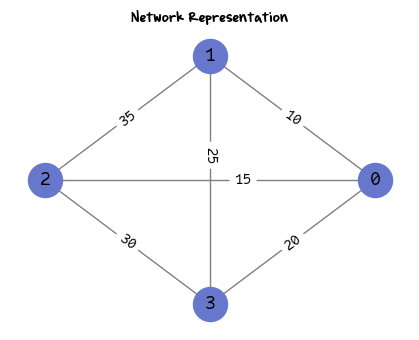

In [19]:
# Represent and draw this network: 
e1 = [[0, 1, 10], [0, 2, 15], [0, 3, 20], [1, 2, 35], [1, 3, 25], [2, 3, 30]]

G1 = read.get_nx_network(edges=e1, directed_graph=False, weighted_graph=True)
n1 = len(G1.nodes)

drawer.draw_network(G=G1, figsize=(4, 3), nx_layout='circular', label_pos=0.6, label_pos_map=get_label_pos(n1, e1))

In [20]:
# Run Held-Karp DP on this network. 
M1 = read.get_dist_matrix_from_edges(e1)
res, path = tsp_held_karp_dp(dist=M1)
print(f'The minimum cost: {res}')
print(f'The optimal path: {path}')

The minimum cost: 80
The optimal path: [0, 2, 3, 1]
